# Toy-model Ablation Study - Results Processing

In [1]:
import os
import pickle
import pandas as pd
import numpy as np

import plotnine as p9

c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


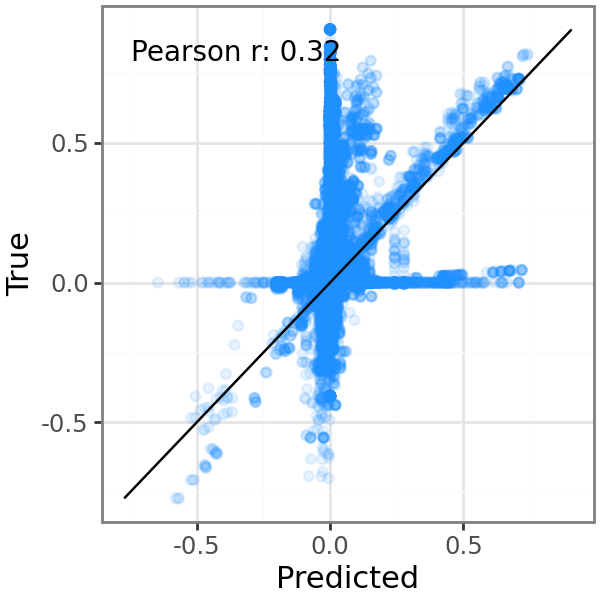

In [ ]:
# How to subtract time point 0 from all other time points
'''from scipy.stats import pearsonr
config_results_path = os.path.join("results", "ablation_study_res", "full_train_results_with_all_hiddenlayers_in_cell.pkl")
data_path = os.path.join(config_results_path)
with open(data_path, "rb") as f:
    cv_results_load = pickle.load(f)
    
# Get test data and Pearson correlation
viz_df_test = cv_results_load["test"]["data"].copy()

y_pred_array = viz_df_test['Predicted'].values
y_true_array = viz_df_test['True'].values
y_pred_array = y_pred_array.reshape(1057, 8, 60)
y_true_array = y_true_array.reshape(1057, 8, 60)

y_pred_array = y_pred_array.transpose(1, 2, 0)
y_true_array = y_true_array.transpose(1, 2, 0)
y_pred_array_ = y_pred_array - y_pred_array[0:1, :, :]
y_true_array_ = y_true_array - y_true_array[0:1, :, :]

mask = ~np.isnan(y_pred_array_) & ~np.isnan(y_true_array_)
y_pred_filtered = y_pred_array_[mask]
y_true_filtered = y_true_array_[mask]

pr, _ = pearsonr(y_pred_filtered, y_true_filtered)
pearson_label = f"Pearson r: {pr:.2f}"

#pearson_label = f"Pearson r {cv_results_load['test']['pearson']:.2f}"
pearson_label = f"Pearson r: {pr:.2f}"

viz_df = pd.DataFrame({
    'Predicted': y_pred_filtered,
    'True': y_true_filtered
})
min_val = min(viz_df['Predicted'].min(), viz_df['True'].min())
max_val = max(viz_df['Predicted'].max(), viz_df['True'].max())
line_df = pd.DataFrame({'x': [min_val, max_val], 'y': [min_val, max_val]})

width, height = 3, 3
p3 = (
    p9.ggplot(viz_df) +
    p9.geom_point(mapping=p9.aes(x='Predicted', y='True'), color='#1E90FF', alpha=0.1) +
    p9.geom_line(data=line_df, mapping=p9.aes(x='x', y='y'), color='black') +
    p9.theme_bw() +
    p9.theme(figure_size=(width, height)) +
    p9.annotate(
        geom='text',
        x=min_val + 0.25*(max_val-min_val),
        y=max_val - 0.05*(max_val-min_val),
        label=pearson_label, 
        size=10)
)
p3.show()'''

In [5]:
config_names = [
    #"initial",
    #"with_time",
    #"with_time_with_phospho",
    #"with_time_with_phospho_with_bcell",
    #"with_all",
    "with_all_hiddenlayers_in_cell",
    #"random"
]

results_folder = os.path.join("results", "ablation_study_res")

train_data_list = []
train_metrics_list = []
test_data_list = []
test_metrics_list = []

# Loop over configuration names to load each file
for name in config_names:
    # File name format: "cv_results_{config}.pkl"
    filename = f"cv_results_{name}.pkl"
    filepath = os.path.join(results_folder, filename)
    print(f"Loading file: {filepath}")
    # Load the cv_results list from each file
    with open(filepath, "rb") as f:
        cv_results = pickle.load(f)
    
    # Each file is a list of folds (each fold is a dictionary)
    for fold_dict in cv_results:
        cv_set = fold_dict["fold"]  # fold+1 provided in the dictionary
        
        train_df = fold_dict["train"]["data"].copy()
        train_df["CV_set"] = cv_set
        train_df["config"] = name
        train_data_list.append(train_df)
        
        train_metrics_list.append({
            "CV_set": cv_set,
            "config": name,
            "train_pearson": fold_dict["train"]["pearson"],
            "training_time": fold_dict["train"]["training_time"]
        })
        
        test_df = fold_dict["test"]["data"].copy()
        test_df["CV_set"] = cv_set
        test_df["config"] = name
        test_data_list.append(test_df)
        
        test_metrics_list.append({
            "CV_set": cv_set,
            "config": name,
            "test_pearson": fold_dict["test"]["pearson"]
        })

# concatenate all collected dataframes/metrics
train_data_concat = pd.concat(train_data_list, ignore_index=True)
train_metrics_df = pd.DataFrame(train_metrics_list)
test_data_concat = pd.concat(test_data_list, ignore_index=True)
test_metrics_df = pd.DataFrame(test_metrics_list)

Loading file: results\ablation_study_res\cv_results_with_all_hiddenlayers_in_cell.pkl


C:\Users\kanto\AppData\Local\Temp\ipykernel_11276\3392558651.py:42: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


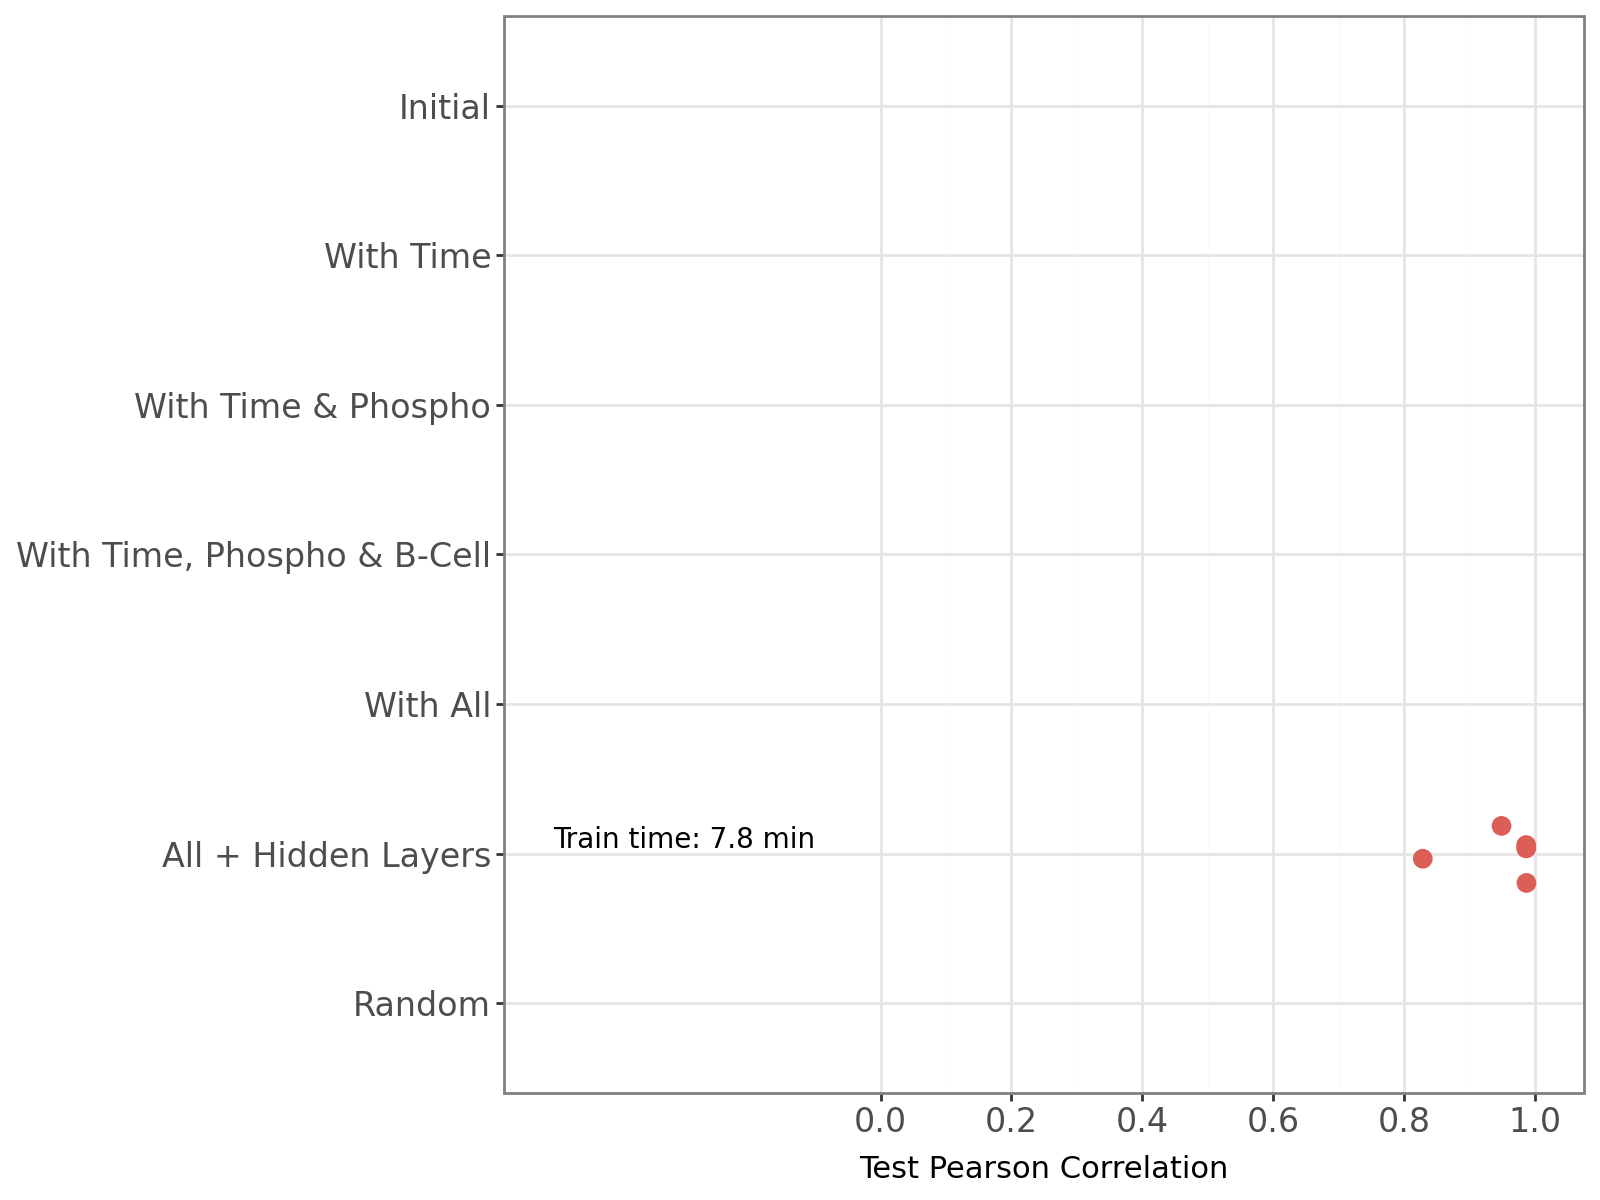

In [6]:
time_df = train_metrics_df.groupby("config", as_index=False)["training_time"].mean()
max_pearson_df = test_metrics_df.groupby("config", as_index=False)["test_pearson"].max()

annot_df = pd.merge(time_df, max_pearson_df, on="config")
annot_df["label"] = "Train time: " + (annot_df["training_time"] / 60).round(1).astype(str) + " min"
annot_df["xpos"] = -0.3

config_order = [
    "random",
    "with_all_hiddenlayers_in_cell",
    "with_all",
    "with_time_with_phospho_with_bcell",
    "with_time_with_phospho",
    "with_time",
    "initial"
]
config_labels = {
    "with_all_hiddenlayers_in_cell": "All + Hidden Layers",
    "with_all": "With All",
    "with_time_with_phospho_with_bcell": "With Time, Phospho & B-Cell",
    "with_time_with_phospho": "With Time & Phospho",
    "with_time": "With Time",
    "initial": "Initial",
    "random": "Random"
}

p = (p9.ggplot(test_metrics_df, p9.aes(x="test_pearson", y="config"))
     + p9.geom_jitter(p9.aes(color="config"), width=0, height=0.2, size=3)
     + p9.geom_text(data=annot_df, mapping=p9.aes(x="xpos", y="config", label="label"), 
                 size=10, va="bottom")
     + p9.labs(x="Test Pearson Correlation",
            y="")
     + p9.scale_x_continuous(limits=(-0.5, 1), breaks=np.arange(0, 1.01, 0.2))
     + p9.scale_y_discrete(limits=config_order, labels=config_labels)
     + p9.theme_bw()
     + p9.theme(figure_size=(8, 6),
             axis_text_y=p9.element_text(size=12),
             axis_text_x=p9.element_text(size=12),
             legend_position="none")
    )

print(p)